In [1]:
import numpy as np
import time 

%load_ext autoreload
%autoreload 2

 read in labels in 0.042897 s
read in array data in 64.989205 s


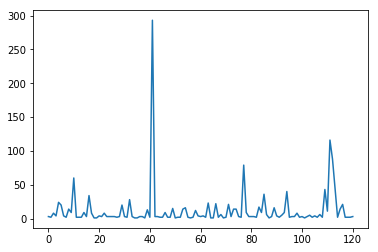

In [2]:
# read in microarray info , arrayid is stored in idlist
TypeSet = set()

tic = time.time()
i = 0
with open("Gene_Chip_Data/E-TABM-185.sdrf.txt") as f:
    for line in f:
        splitlist = line.split("\t")
        if(i == 0):
            pass
        else:
            cell_type = splitlist[4]
            # throw away datas with no labels
            if(cell_type != "  "):
                TypeSet.add(cell_type)
        i += 1

TypeDict = {}
j = 0
for i in TypeSet:
    TypeDict[i] = j
    j += 1

# print "Mapping relationship"
# for i in TypeDict.keys():
#     print i,"------>",TypeDict[i]

i = 0
Labels = []
with open("Gene_Chip_Data/E-TABM-185.sdrf.txt") as f:
    for line in f:
        splitlist = line.split("\t")
        if(i == 0):
            pass
        else:
            hyber_name = splitlist[14]
            cell_type = splitlist[4]
            if not(cell_type[0] == " "):
                Labels.append(TypeDict[cell_type])
            else:
                Labels.append(-1)
        i += 1
toc = time.time()

print " read in labels in %f s" % (toc-tic)

# read in microarray info , arrayid is stored in idlist
GeneID = []
ProbeSetID = []
RawArray = np.zeros([5896,22283])

tic = time.time()
i = 0
with open("Gene_Chip_Data/microarray.original.txt") as f:
    for line in f:
        splitlist = line.split("\t")
        if(i == 0):
            for j in splitlist:
                ProbeSetID.append(j)
        else:
            GeneID.append(splitlist[0])
            RawArray[:,i-1] = np.asarray(splitlist[1:])
        i += 1
toc = time.time()

print "read in array data in %f s" % (toc-tic)

Labels = np.asarray(Labels)
mask = (Labels != -1)
MicroArray = RawArray[mask,:]
Labels = Labels[mask]

distribution = np.zeros(len(TypeSet))

for i in range(len(Labels)):
    distribution[int(Labels[i])] += 1

import matplotlib.pyplot as plt
plt.plot(distribution)
plt.show()

In [3]:
filter = []
for idx,val in enumerate(Labels):
    if(distribution[val] >= 5):
        filter.append(idx)
#print len(filter)

MicroArray = MicroArray[filter,:]
Labels = Labels[filter]
print MicroArray.shape
Labels = Labels.reshape([1297,1])
print Labels.shape

#totally 45 classes
print np.sum(distribution >= 5)

(1297, 22283)
(1297, 1)
45


In [4]:
import tensorflow as tf
# creating nodes for the input images and target output classes.
sess = tf.InteractiveSession()
global_step_tensor = tf.Variable(0, trainable=False, name='global_step')
x = tf.placeholder(tf.float32, shape=[None, 22283])
y_ = tf.placeholder(tf.float32, shape=[None, 22283])
reg_penalty = 1e-4

W1 = tf.Variable(
    tf.random_normal(shape = [22283,2000],mean=0.001,stddev=0.1),name = "W1"
)
b1 = tf.Variable(
    tf.random_normal(shape = [2000],mean=0.001,stddev=0.1),name = "b1"
)
n1 = reg_penalty * (tf.reduce_sum(tf.square(W1)) + tf.reduce_sum(tf.square(b1)))
y1 = tf.matmul(x,W1) + b1
#o1 = tf.sigmoid(y1)
o1 = tf.nn.relu(y1)

W2 = tf.Variable(
    tf.random_normal(shape = [2000,200],mean=0.001,stddev=0.1),name = "W2"
)
b2 = tf.Variable(
    tf.random_normal(shape = [200],mean=0.001,stddev=0.1),name = "b2"
)
n2 = reg_penalty * (tf.reduce_sum(tf.square(W2)) + tf.reduce_sum(tf.square(b2)))
y2 = tf.matmul(o1,W2) + b2
#o2 = tf.sigmoid(y2)
o2 = tf.nn.relu(y2)

W3 = tf.Variable(
    tf.random_normal(shape = [200,100],mean=0.001,stddev=0.1),name = "W3"
)
b3 = tf.Variable(
    tf.random_normal(shape = [100],mean=0.001,stddev=0.1),name = "b3"
)
n3 = reg_penalty * (tf.reduce_sum(tf.square(W3)) + tf.reduce_sum(tf.square(b3)))
y3 = tf.matmul(o2,W3) + b3
#o3 = tf.sigmoid(y3)
o3 = tf.nn.relu(y3)

W4 = tf.Variable(
    tf.random_normal(shape = [100,22283],mean=0.001,stddev=0.1),name = "W4"
)
b4 = tf.Variable(
    tf.random_normal(shape = [22283],mean=0.001,stddev=0.1),name = "b4"
)
n4 = reg_penalty * (tf.reduce_sum(tf.square(W4)) + tf.reduce_sum(tf.square(b4)))
y4 = tf.matmul(o3,W4) + b4

mse_error = tf.losses.mean_squared_error(labels = y_,predictions = y4)

loss = mse_error + n1 + n2 + n3 + n4

In [31]:
opt = tf.train.GradientDescentOptimizer(learning_rate=1e-2)
train_step = opt.minimize(loss, global_step = global_step_tensor)

In [41]:
def eval_loss():
    l = tf.identity(loss).eval(feed_dict={x: MicroArray, y_: MicroArray})
    return l

In [42]:
def eval_mse_loss():
    l = tf.identity(mse_error).eval(feed_dict={x: MicroArray, y_: MicroArray})
    return l

In [32]:
saver = tf.train.Saver({"W1": W1,"b1":b1,
                        "W2": W2,"b1":b2,
                        "W3": W3,"b1":b3,
                        "W4": W4,"b1":b4,})
saver.restore(sess, "./models/pre_train_para.ckpt")

INFO:tensorflow:Restoring parameters from ./models/pre_train_para.ckpt


In [33]:
tf.variables_initializer([global_step_tensor]).run()

In [43]:
print eval_loss()
print eval_mse_loss()

83.2175
34.6487


In [45]:
print np.mean(MicroArray,axis=0)

[ 5.60610301  6.81111517  4.87755607 ...,  3.17587017  2.45701003
  3.08785588]


In [11]:
loss_his = []

In [39]:
batch_size = 100
epoch = int(MicroArray.shape[0] / batch_size)
for step in range(10 * epoch):
  random = np.random.choice(1297,batch_size,replace=False)
  feed_dict = {x: MicroArray[random,:], y_: MicroArray[random,:]}
  _,a = sess.run([train_step,loss],feed_dict=feed_dict)
  loss_his.append(a)
  if(step % epoch == 0):
    print "epoch:%d    loss:%f" % (step/epoch,a)
#   if(step%1000 == 0):
#     print str(step) + " completed"
#     save_model()

epoch:0    loss:83.222412
epoch:1    loss:83.072891
epoch:2    loss:83.235909
epoch:3    loss:83.054352


KeyboardInterrupt: 

In [14]:
print loss_his

[1232568.4]


83.2343


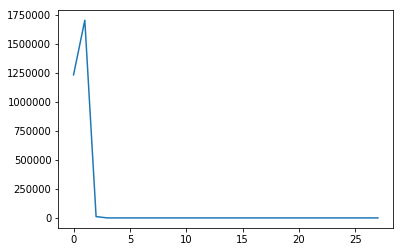

In [35]:
loss_his_cut = np.asarray(loss_his)
plt.plot(loss_his_cut)
print loss_his_cut[len(loss_his_cut)-1]
plt.show()

In [17]:
tf.global_variables()

[<tf.Variable 'global_step:0' shape=() dtype=int32_ref>,
 <tf.Variable 'W1:0' shape=(22283, 2000) dtype=float32_ref>,
 <tf.Variable 'b1:0' shape=(2000,) dtype=float32_ref>,
 <tf.Variable 'W2:0' shape=(2000, 200) dtype=float32_ref>,
 <tf.Variable 'b2:0' shape=(200,) dtype=float32_ref>,
 <tf.Variable 'W3:0' shape=(200, 100) dtype=float32_ref>,
 <tf.Variable 'b3:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'W4:0' shape=(100, 22283) dtype=float32_ref>,
 <tf.Variable 'b4:0' shape=(22283,) dtype=float32_ref>]

In [21]:
saver = tf.train.Saver({"W1": W1,"b1":b1,
                        "W2": W2,"b1":b2,
                        "W3": W3,"b1":b3,
                        "W4": W4,"b1":b4,})
saver.save(sess, "./models/pre_train_para.ckpt")

'./models/pre_train_para.ckpt'

In [36]:
approx = tf.identity(y4).eval(feed_dict={x: MicroArray})

In [37]:
def rel_error(x, y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [38]:
print rel_error(approx,MicroArray)

1.0


In [ ]:
np.mean()